In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, torch, pickle, csv
import numpy as np
import scipy as sp
sys.path.append('/lfs/1/danfu/metal')
sys.path.append('/lfs/1/danfu/sequential_ws')
from metal.metrics import metric_score
from torch.nn.functional import normalize
from DP.label_model import *
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda:0')

# Load Data

In [5]:
L_train_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_train_100_windows_downsampled.npz'
L_dev_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_val_windows_downsampled_same_val_test.npz'
Y_dev_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/Y_val_windows_downsampled_same_val_test.npy'
L_test_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_test_windows_downsampled_same_val_test.npz'
Y_test_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/Y_test_windows_downsampled_same_val_test.npy'

stride = 1
L_train_raw = sp.sparse.load_npz(L_train_path).todense()[::stride]
L_dev_raw = sp.sparse.load_npz(L_dev_path).todense()
Y_dev_raw = np.load(Y_dev_path)
L_test_raw = sp.sparse.load_npz(L_test_path).todense()
Y_test_raw = np.load(Y_test_path)

T = 5

L_train = torch.FloatTensor(L_train_raw[:L_train_raw.shape[0] - (L_train_raw.shape[0] % T)]).to(device)
L_dev = torch.FloatTensor(L_dev_raw[:L_dev_raw.shape[0] - (L_dev_raw.shape[0] % T)]).to(device)
Y_dev = torch.FloatTensor(Y_dev_raw[:Y_dev_raw.shape[0] - (Y_dev_raw.shape[0] % T)]).to(device)
L_test = torch.FloatTensor(L_test_raw[:L_test_raw.shape[0] - (L_test_raw.shape[0] % T)]).to(device)
Y_test = torch.FloatTensor(Y_test_raw[:Y_test_raw.shape[0] - (Y_test_raw.shape[0] % T)]).to(device)
m_per_task = L_train.size(1)
n_frames_train = L_train.size(0)
n_patients_train = n_frames_train//T
n_frames_dev = L_dev.size(0)
n_patients_dev = n_frames_dev//T
n_frames_test = L_test.size(0)
n_patients_test = n_frames_test//T

# MRI_data_naive = {'Li_train': (L_train.unsqueeze(2) == torch.FloatTensor([-1,1,0]).to(device).unsqueeze(0).unsqueeze(0)).argmax(2),
#                   'Li_dev': (L_dev.unsqueeze(2) == torch.FloatTensor([-1,1,0]).to(device).unsqueeze(0).unsqueeze(0)).argmax(2),
#                   'R_dev': (Y_dev.unsqueeze(1) == torch.FloatTensor([-1,1]).to(device).unsqueeze(0)).argmax(1),
#                   'm':m_per_task, 'T':1,
#                  }

# don't need to transform the raw data
MRI_data_naive = {'Li_train': L_train.long().to(device),
                  'Li_dev': L_dev.long().to(device),
                  'R_dev': Y_dev.long().to(device),
                  'Li_test': L_test.long().to(device),
                  'R_test': Y_test.long().to(device),
                  'm':m_per_task, 'T':1,
                 }
MRI_data_naive['class_balance'] = normalize((MRI_data_naive['R_dev'].unsqueeze(1)==torch.arange(2, device=device).unsqueeze(0)).sum(0).float(), 
                                            dim=0, p=1)
MRI_data_temporal = {'Li_train': MRI_data_naive['Li_train'].view(n_patients_train, (m_per_task*T)),
                     'Li_dev': MRI_data_naive['Li_dev'].view(n_patients_dev, (m_per_task*T)),
                     'R_dev': MRI_data_naive['R_dev']*(2**T-1),
                     'Li_test': MRI_data_naive['Li_test'].view(n_patients_test, (m_per_task*T)),
                     'R_test': MRI_data_naive['R_test']*(2**T-1),
                     'm': m_per_task * T, 'T': T,
                    } 
MRI_data_temporal['class_balance'] = normalize((MRI_data_temporal['R_dev'].unsqueeze(1)==torch.arange(2**T, device=device).unsqueeze(0)).sum(0).float(), 
                                                dim=0, p=1)

# Naive Model

In [12]:
MRI_data_naive['class_balance']

tensor([0., 1.], device='cuda:0')

In [5]:
naive_model = DPLabelModel(m=m_per_task, 
                           T=1,
                           edges=[],
                           coverage_sets=[[0,]]*m_per_task,
                           mu_sharing=[[i,] for i in range(m_per_task)],
                           phi_sharing=[],
                           device=device,
                           # class_balance=MRI_data_naive['class_balance'], 
                           seed=0)
optimize(naive_model, L_hat=MRI_data_naive['Li_train'], num_iter=3000, lr=4.087885261759692e-05,
         momentum=0.9, clamp=True, seed=2)

iteration=0 loss=50.6702766418457
iteration=300 loss=8.80715274810791
iteration=600 loss=3.66485595703125
iteration=900 loss=1.8281009197235107
iteration=1200 loss=0.9653668999671936
iteration=1500 loss=0.6120548844337463
iteration=1800 loss=0.4767417907714844
iteration=2100 loss=0.40450260043144226
iteration=2400 loss=0.3607012629508972
iteration=2700 loss=0.3310929536819458
iteration=2999 loss=0.30959445238113403


In [6]:
R_pred = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.125
F1: 0.389
Recall: 0.712
Precision: 0.268


In [8]:
# Flipping params
print("Flipping Parameters")
naive_model.flip_params()
R_pred_flipped = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred_flipped.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Flipping Parameters
Accuracy: 0.051
F1: 0.143
Recall: 0.288
Precision: 0.095


# Timeseries model

In [1]:
valid_target = Y_dev.long()
T = 5

feasible_y = np.array([[-1, -1, -1, -1, -1],
        [-1,  1, -1, -1, -1],
        [ 1, -1, -1, -1, -1],
        [ 1,  1, -1, -1, -1],
        [-1, -1,  1, -1, -1],
        [-1,  1,  1, -1, -1],
        [ 1, -1,  1, -1, -1],
        [ 1,  1,  1, -1, -1],
        [-1, -1, -1,  1, -1],
        [-1,  1, -1,  1, -1],
        [ 1, -1, -1,  1, -1],
        [ 1,  1, -1,  1, -1],
        [-1, -1,  1,  1, -1],
        [-1,  1,  1,  1, -1],
        [ 1, -1,  1,  1, -1],
        [ 1,  1,  1,  1, -1],
        [-1, -1, -1, -1,  1],
        [-1,  1, -1, -1,  1],
        [ 1, -1, -1, -1,  1],
        [ 1,  1, -1, -1,  1],
        [-1, -1,  1, -1,  1],
        [-1,  1,  1, -1,  1],
        [ 1, -1,  1, -1,  1],
        [ 1,  1,  1, -1,  1],
        [-1, -1, -1,  1,  1],
        [-1,  1, -1,  1,  1],
        [ 1, -1, -1,  1,  1],
        [ 1,  1, -1,  1,  1],
        [-1, -1,  1,  1,  1],
        [-1,  1,  1,  1,  1],
        [ 1, -1,  1,  1,  1],
        [ 1,  1,  1,  1,  1]])

feasible_y[feasible_y==-1] = 0
feasible_y = feasible_y.tolist()
possibilities = list(map(lambda l : ''.join(map(str,l)), feasible_y))

class_balance = np.empty(2 ** T)
#compute class balance from dev set and use laplace smoothing

valid_target_copy = np.copy(valid_target)
valid_target_copy[valid_target_copy == 2] = 0

assert len(valid_target_copy) % T == 0
num_windows = len(valid_target_copy) / T

freq = {}
for i in range(0, len(valid_target_copy), T):
    s = ''.join(map(str,valid_target_copy[i:i+T]))
    if s in freq:
        freq[s] += 1
    else:
        freq[s] = 1

for i in range(len(class_balance)):
    if possibilities[i] in freq and freq[possibilities[i]] > 5:
        class_balance[i] = (freq[possibilities[i]] + 1) / (num_windows + len(possibilities))
    else:
        class_balance[i] = 0.

NameError: name 'Y_dev' is not defined

In [7]:
%%time
best = None
for iterations in [1, 5,10, 25, 50, 100, 200]:
    for learning_rate in [1e-4, 1e-5, 1e-6, 1e-7]:
        print(iterations, learning_rate)
        max_seed = 10
        temporal_models = [None,]*max_seed
        for seed in range(max_seed):
            print(seed)
            markov_model = DPLabelModel(m=m_per_task*T, 
                                        T=T,
                                        edges=[(i,i+m_per_task) for i in range((T-1)*m_per_task)],
                                        coverage_sets=[[t,] for t in range(T) for _ in range(m_per_task)],
                                        mu_sharing=[[t*m_per_task+i for t in range(T)] for i in range(m_per_task)],
                                        phi_sharing=[[(t*m_per_task+i, (t+1)*m_per_task+i)
                                                      for t in range(T-1)] for i in range(m_per_task)],
                                        device=device,
                                        class_balance=torch.tensor(class_balance).float().to(device),
                                        seed=seed)
            optimize(markov_model, L_hat=MRI_data_temporal['Li_train'], num_iter=iterations,
                     lr=1e-5, momentum=0.8, clamp=True, 
                     verbose=iterations >= 10, seed=seed)
            temporal_models[seed] = markov_model

        for seed, model in enumerate(temporal_models):
            Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
            R_pred_frame_label = model.predict_element_proba(Li_dev.to(device)) #predict per element

            scores = [iterations, seed, model]
            for metric in ['accuracy', 'f1', 'recall', 'precision']:
                score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
                print(f"{metric.capitalize()}: {score:.3f}")

                scores.append(score)
                
            model.flip_params()
            R_pred_frame_label = model.predict_element_proba(Li_dev.to(device)) #predict per element

            for metric in ['accuracy', 'f1', 'recall', 'precision']:
                score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
                print(f"{metric.capitalize()}: {score:.3f}")

                scores.append(score)
            
            model.flip_params()

            if best == None or scores[4] > max(best[4], best[8]) or scores[8] > max(best[4], best[8]):
                best = scores
            print()

print(best)

1 0.0001
0
1
2
3
4
5
6
7
8
9
Accuracy: 0.057
F1: 0.443
Recall: 0.299
Precision: 0.851
Accuracy: 0.001
F1: 0.005
Recall: 0.003
Precision: 0.012

Accuracy: 0.029
F1: 0.233
Recall: 0.151
Precision: 0.510
Accuracy: 0.036
F1: 0.202
Recall: 0.189
Precision: 0.217

Accuracy: 0.073
F1: 0.379
Recall: 0.384
Precision: 0.375
Accuracy: 0.010
F1: 0.072
Recall: 0.052
Precision: 0.115

Accuracy: 0.075
F1: 0.532
Recall: 0.395
Precision: 0.814
Accuracy: 0.017
F1: 0.070
Recall: 0.090
Precision: 0.057

Accuracy: 0.052
F1: 0.363
Recall: 0.276
Precision: 0.528
Accuracy: 0.002
F1: 0.023
Recall: 0.012
Precision: 0.800

Accuracy: 0.007
F1: 0.033
Recall: 0.035
Precision: 0.031
Accuracy: 0.127
F1: 0.762
Recall: 0.669
Precision: 0.885

Accuracy: 0.009
F1: 0.050
Recall: 0.049
Precision: 0.050
Accuracy: 0.139
F1: 0.775
Recall: 0.733
Precision: 0.824

Accuracy: 0.012
F1: 0.046
Recall: 0.061
Precision: 0.037
Accuracy: 0.053
F1: 0.434
Recall: 0.282
Precision: 0.942

Accuracy: 0.002
F1: 0.010
Recall: 0.012
Precision: 


5 1e-07
0
1
2
3
4
5
6
7
8
9
Accuracy: 0.071
F1: 0.510
Recall: 0.372
Precision: 0.810
Accuracy: 0.005
F1: 0.036
Recall: 0.026
Precision: 0.056

Accuracy: 0.107
F1: 0.678
Recall: 0.567
Precision: 0.844
Accuracy: 0.022
F1: 0.121
Recall: 0.116
Precision: 0.127

Accuracy: 0.066
F1: 0.338
Recall: 0.349
Precision: 0.328
Accuracy: 0.021
F1: 0.139
Recall: 0.113
Precision: 0.181

Accuracy: 0.099
F1: 0.647
Recall: 0.520
Precision: 0.856
Accuracy: 0.015
F1: 0.060
Recall: 0.078
Precision: 0.048

Accuracy: 0.069
F1: 0.508
Recall: 0.363
Precision: 0.845
Accuracy: 0.001
F1: 0.010
Recall: 0.006
Precision: 0.029

Accuracy: 0.010
F1: 0.078
Recall: 0.052
Precision: 0.151
Accuracy: 0.088
F1: 0.587
Recall: 0.462
Precision: 0.803

Accuracy: 0.008
F1: 0.049
Recall: 0.044
Precision: 0.056
Accuracy: 0.116
F1: 0.588
Recall: 0.613
Precision: 0.564

Accuracy: 0.088
F1: 0.430
Recall: 0.465
Precision: 0.400
Accuracy: 0.008
F1: 0.080
Recall: 0.044
Precision: 0.455

Accuracy: 0.005
F1: 0.031
Recall: 0.026
Precision: 

iteration=8 loss=2565.739990234375
iteration=9 loss=2513.0263671875
iteration=9 loss=2513.0263671875
6
iteration=0 loss=8174.98974609375
iteration=1 loss=5998.1923828125
iteration=2 loss=4221.92578125
iteration=3 loss=3303.88330078125
iteration=4 loss=2907.792724609375
iteration=5 loss=2792.9462890625
iteration=6 loss=2821.293701171875
iteration=7 loss=2883.26806640625
iteration=8 loss=2854.052734375
iteration=9 loss=2759.062744140625
iteration=9 loss=2759.062744140625
7
iteration=0 loss=9998.80078125
iteration=1 loss=6405.28564453125
iteration=2 loss=4114.892578125
iteration=3 loss=3167.1005859375
iteration=4 loss=2847.634765625
iteration=5 loss=2825.556640625
iteration=6 loss=2935.91259765625
iteration=7 loss=3045.556884765625
iteration=8 loss=3015.14453125
iteration=9 loss=2852.78759765625
iteration=9 loss=2852.78759765625
8
iteration=0 loss=10594.029296875
iteration=1 loss=7058.30029296875
iteration=2 loss=4665.5537109375
iteration=3 loss=3581.22705078125
iteration=4 loss=3126.6162

iteration=7 loss=2480.36669921875
iteration=8 loss=2407.119384765625
iteration=9 loss=2311.55517578125
iteration=9 loss=2311.55517578125
2
iteration=0 loss=6010.771484375
iteration=1 loss=5289.08642578125
iteration=2 loss=4410.51953125
iteration=3 loss=3701.227294921875
iteration=4 loss=3216.73193359375
iteration=5 loss=2919.48681640625
iteration=6 loss=2761.02197265625
iteration=7 loss=2693.2255859375
iteration=8 loss=2665.072265625
iteration=9 loss=2628.21142578125
iteration=9 loss=2628.21142578125
3
iteration=0 loss=4199.771484375
iteration=1 loss=3921.1005859375
iteration=2 loss=3544.753173828125
iteration=3 loss=3205.98828125
iteration=4 loss=2954.3408203125
iteration=5 loss=2788.410888671875
iteration=6 loss=2687.43212890625
iteration=7 loss=2625.00732421875
iteration=8 loss=2575.043212890625
iteration=9 loss=2516.919189453125
iteration=9 loss=2516.919189453125
4
iteration=0 loss=5909.1123046875
iteration=1 loss=4997.9970703125
iteration=2 loss=4011.04052734375
iteration=3 loss=3

iteration=2 loss=4665.5537109375
iteration=4 loss=3126.6162109375
iteration=6 loss=2955.490234375
iteration=8 loss=2868.6474609375
iteration=10 loss=2543.1083984375
iteration=12 loss=2176.965087890625
iteration=14 loss=1898.752197265625
iteration=16 loss=1722.412841796875
iteration=18 loss=1609.00341796875
iteration=20 loss=1527.7679443359375
iteration=22 loss=1459.6649169921875
iteration=24 loss=1392.427734375
iteration=24 loss=1392.427734375
9
iteration=0 loss=5845.88818359375
iteration=2 loss=3951.827392578125
iteration=4 loss=2815.603515625
iteration=6 loss=2424.966064453125
iteration=8 loss=2321.52734375
iteration=10 loss=2191.009521484375
iteration=12 loss=1944.0787353515625
iteration=14 loss=1673.101318359375
iteration=16 loss=1466.5843505859375
iteration=18 loss=1324.346435546875
iteration=20 loss=1219.568603515625
iteration=22 loss=1137.6453857421875
iteration=24 loss=1078.4256591796875
iteration=24 loss=1078.4256591796875
Accuracy: 0.135
F1: 0.683
Recall: 0.712
Precision: 0.6

iteration=4 loss=3179.128662109375
iteration=6 loss=2773.415771484375
iteration=8 loss=2649.3662109375
iteration=10 loss=2467.298095703125
iteration=12 loss=2286.616455078125
iteration=14 loss=2095.920166015625
iteration=16 loss=1920.3570556640625
iteration=18 loss=1780.140625
iteration=20 loss=1671.983642578125
iteration=22 loss=1587.9288330078125
iteration=24 loss=1525.505859375
iteration=24 loss=1525.505859375
1
iteration=0 loss=6173.22900390625
iteration=2 loss=4018.0478515625
iteration=4 loss=2795.703369140625
iteration=6 loss=2503.117919921875
iteration=8 loss=2407.119384765625
iteration=10 loss=2195.864013671875
iteration=12 loss=1940.2430419921875
iteration=14 loss=1703.6090087890625
iteration=16 loss=1528.538818359375
iteration=18 loss=1412.1640625
iteration=20 loss=1337.7255859375
iteration=22 loss=1287.14599609375
iteration=24 loss=1213.020263671875
iteration=24 loss=1213.020263671875
2
iteration=0 loss=6010.771484375
iteration=2 loss=4410.51953125
iteration=4 loss=3216.7319

iteration=16 loss=1822.406982421875
iteration=18 loss=1735.4365234375
iteration=20 loss=1648.56298828125
iteration=22 loss=1559.448486328125
iteration=24 loss=1474.685791015625
iteration=24 loss=1474.685791015625
5
iteration=0 loss=5901.8134765625
iteration=2 loss=4062.97607421875
iteration=4 loss=2958.609619140625
iteration=6 loss=2642.4736328125
iteration=8 loss=2565.739990234375
iteration=10 loss=2431.718505859375
iteration=12 loss=2199.711181640625
iteration=14 loss=1959.55322265625
iteration=16 loss=1782.412109375
iteration=18 loss=1666.940185546875
iteration=20 loss=1587.555908203125
iteration=22 loss=1526.6484375
iteration=24 loss=1470.9847412109375
iteration=24 loss=1470.9847412109375
6
iteration=0 loss=8174.98974609375
iteration=2 loss=4221.92578125
iteration=4 loss=2907.792724609375
iteration=6 loss=2821.293701171875
iteration=8 loss=2854.052734375
iteration=10 loss=2615.05419921875
iteration=12 loss=2285.84765625
iteration=14 loss=2040.1253662109375
iteration=16 loss=1909.21


Accuracy: 0.004
F1: 0.041
Recall: 0.023
Precision: 0.186
Accuracy: 0.015
F1: 0.142
Recall: 0.081
Precision: 0.560

Accuracy: 0.029
F1: 0.137
Recall: 0.154
Precision: 0.123
Accuracy: 0.121
F1: 0.696
Recall: 0.637
Precision: 0.768

Accuracy: 0.004
F1: 0.036
Recall: 0.020
Precision: 0.163
Accuracy: 0.037
F1: 0.294
Recall: 0.195
Precision: 0.598

Accuracy: 0.006
F1: 0.051
Recall: 0.029
Precision: 0.208
Accuracy: 0.061
F1: 0.460
Recall: 0.320
Precision: 0.821

Accuracy: 0.003
F1: 0.031
Recall: 0.017
Precision: 0.146
Accuracy: 0.091
F1: 0.621
Recall: 0.480
Precision: 0.882

Accuracy: 0.001
F1: 0.006
Recall: 0.003
Precision: 0.500
Accuracy: 0.034
F1: 0.282
Recall: 0.180
Precision: 0.653

50 1e-05
0
iteration=0 loss=5474.5625
iteration=5 loss=2916.369873046875
iteration=10 loss=2467.298095703125
iteration=15 loss=2004.2828369140625
iteration=20 loss=1671.983642578125
iteration=25 loss=1500.6927490234375
iteration=30 loss=1357.379150390625
iteration=35 loss=1238.488037109375
iteration=40 loss=

iteration=10 loss=2615.05419921875
iteration=15 loss=1963.2392578125
iteration=20 loss=1775.3250732421875
iteration=25 loss=1584.427001953125
iteration=30 loss=1429.028076171875
iteration=35 loss=1297.962646484375
iteration=40 loss=1191.1910400390625
iteration=45 loss=1102.8558349609375
iteration=49 loss=1042.1461181640625
7
iteration=0 loss=9998.80078125
iteration=5 loss=2825.556640625
iteration=10 loss=2634.830810546875
iteration=15 loss=1837.097412109375
iteration=20 loss=1642.0953369140625
iteration=25 loss=1426.9168701171875
iteration=30 loss=1270.780517578125
iteration=35 loss=1140.966796875
iteration=40 loss=1039.478271484375
iteration=45 loss=961.5462646484375
iteration=49 loss=910.909912109375
8
iteration=0 loss=10594.029296875
iteration=5 loss=2969.663330078125
iteration=10 loss=2543.1083984375
iteration=15 loss=1799.749755859375
iteration=20 loss=1527.7679443359375
iteration=25 loss=1356.2200927734375
iteration=30 loss=1195.76513671875
iteration=35 loss=1079.3731689453125
it

iteration=30 loss=1049.43798828125
iteration=40 loss=862.2739868164062
iteration=50 loss=743.9108276367188
iteration=60 loss=666.1441040039062
iteration=70 loss=610.3531494140625
iteration=80 loss=567.1578979492188
iteration=90 loss=537.26806640625
iteration=99 loss=515.082275390625
2
iteration=0 loss=6010.771484375
iteration=10 loss=2551.470458984375
iteration=20 loss=1540.8245849609375
iteration=30 loss=1210.9149169921875
iteration=40 loss=1009.1867065429688
iteration=50 loss=869.088134765625
iteration=60 loss=770.5421142578125
iteration=70 loss=696.7645263671875
iteration=80 loss=642.19580078125
iteration=90 loss=598.3699340820312
iteration=99 loss=565.8165283203125
3
iteration=0 loss=4199.771484375
iteration=10 loss=2439.8662109375
iteration=20 loss=1607.2415771484375
iteration=30 loss=1282.6077880859375
iteration=40 loss=1049.369140625
iteration=50 loss=894.216552734375
iteration=60 loss=789.1647338867188
iteration=70 loss=712.5748901367188
iteration=80 loss=657.9627685546875
iter

iteration=30 loss=952.5345458984375
iteration=40 loss=822.9971923828125
iteration=50 loss=738.7559204101562
iteration=60 loss=676.3593139648438
iteration=70 loss=627.4212646484375
iteration=80 loss=587.8203735351562
iteration=90 loss=555.3527221679688
iteration=99 loss=531.1490478515625
Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.075
F1: 0.518
Recall: 0.395
Precision: 0.751

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.061
F1: 0.463
Recall: 0.323
Precision: 0.822

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.056
F1: 0.418
Recall: 0.297
Precision: 0.708

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.008
F1: 0.082
Recall: 0.044
Precision: 0.652

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.023
F1: 0.200
Recall: 0.122
Precision: 0.560

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.041
F1: 0.346
Recall: 0.215
Precision: 0.881

Accuracy: 0.001
F1: 0.

iteration=40 loss=1028.272216796875
iteration=50 loss=877.371826171875
iteration=60 loss=778.4125366210938
iteration=70 loss=707.5772094726562
iteration=80 loss=656.8345947265625
iteration=90 loss=616.321044921875
iteration=99 loss=586.3966064453125
5
iteration=0 loss=5901.8134765625
iteration=10 loss=2431.718505859375
iteration=20 loss=1587.555908203125
iteration=30 loss=1297.69677734375
iteration=40 loss=1091.114013671875
iteration=50 loss=929.9364624023438
iteration=60 loss=804.29931640625
iteration=70 loss=710.1395874023438
iteration=80 loss=638.6434326171875
iteration=90 loss=583.5235595703125
iteration=99 loss=544.1700439453125
6
iteration=0 loss=8174.98974609375
iteration=10 loss=2615.05419921875
iteration=20 loss=1775.3250732421875
iteration=30 loss=1429.028076171875
iteration=40 loss=1191.1910400390625
iteration=50 loss=1028.1865234375
iteration=60 loss=909.41259765625
iteration=70 loss=819.3133544921875
iteration=80 loss=752.3092041015625
iteration=90 loss=699.2025146484375
i

Accuracy: 0.111
F1: 0.690
Recall: 0.584
Precision: 0.841

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.053
F1: 0.430
Recall: 0.282
Precision: 0.907

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000
Accuracy: 0.110
F1: 0.693
Recall: 0.581
Precision: 0.858

200 1e-05
0
iteration=0 loss=5474.5625
iteration=20 loss=1671.983642578125
iteration=40 loss=1130.2415771484375
iteration=60 loss=856.2899169921875
iteration=80 loss=715.9603881835938
iteration=100 loss=622.6627807617188
iteration=120 loss=557.0338745117188
iteration=140 loss=507.1540222167969
iteration=160 loss=468.8624267578125
iteration=180 loss=439.07403564453125
iteration=199 loss=416.6258544921875
1
iteration=0 loss=6173.22900390625
iteration=20 loss=1337.7255859375
iteration=40 loss=862.2739868164062
iteration=60 loss=666.1441040039062
iteration=80 loss=567.1578979492188
iteration=100 loss=512.8164672851562
iteration=120 loss=474.1331481933594
iteration=140 loss=445.2003173828125
iteration=160 lo

iteration=199 loss=446.2757568359375
7
iteration=0 loss=9998.80078125
iteration=20 loss=1642.0953369140625
iteration=40 loss=1039.478271484375
iteration=60 loss=806.4021606445312
iteration=80 loss=693.2643432617188
iteration=100 loss=620.5284423828125
iteration=120 loss=566.2553100585938
iteration=140 loss=524.3209838867188
iteration=160 loss=491.2142028808594
iteration=180 loss=463.6517333984375
iteration=199 loss=441.34881591796875
8
iteration=0 loss=10594.029296875
iteration=20 loss=1527.7679443359375
iteration=40 loss=981.3070068359375
iteration=60 loss=744.3742065429688
iteration=80 loss=622.3905029296875
iteration=100 loss=547.0148315429688
iteration=120 loss=493.99005126953125
iteration=140 loss=455.2908020019531
iteration=160 loss=428.498046875
iteration=180 loss=407.9398193359375
iteration=199 loss=392.41729736328125
9
iteration=0 loss=5845.88818359375
iteration=20 loss=1219.568603515625
iteration=40 loss=822.9971923828125
iteration=60 loss=676.3593139648438
iteration=80 loss=

In [8]:
best_model = best[2]

In [9]:
R_pred_frame_label = best_model.predict_element_proba(Li_dev.to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.143
F1: 0.806
Recall: 0.756
Precision: 0.864


In [12]:
Li_test = torch.LongTensor(MRI_data_temporal['Li_test'].cpu().numpy())
R_pred_frame_label = best_model.predict_element_proba(Li_test.to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_test.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.120
F1: 0.784
Recall: 0.738
Precision: 0.838


In [9]:
best_model.flip_params()

In [10]:
R_pred_frame_label = best_model.predict_element_proba(Li_dev.to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.083
F1: 0.690
Recall: 0.575
Precision: 0.863


(array([1287.,  184.,   37.,   44.,   26.,   28.,   37.,   29.,   53.,
         120.]),
 array([5.02966725e-06, 9.92960581e-02, 1.98587087e-01, 2.97878115e-01,
        3.97169143e-01, 4.96460172e-01, 5.95751200e-01, 6.95042229e-01,
        7.94333257e-01, 8.93624286e-01, 9.92915314e-01]),
 <a list of 10 Patch objects>)

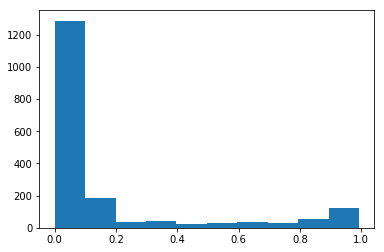

In [14]:
plt.hist(R_pred_frame_label)

In [13]:
torch.save(best_model, 'models/ts_labelmodel_best_tuning_downsampled_same_val_test.pth')

# Save/Load best model

In [15]:
model = best_model

In [3]:
model = torch.load('models/ts_labelmodel.pth').to(device)

In [16]:
R_pred_frame_label = model.eval().predict_element_proba(
    MRI_data_temporal['Li_dev'].to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.143
F1: 0.806
Recall: 0.756
Precision: 0.864


In [17]:
R_pred_frame_label = model.eval().predict_element_proba(
    MRI_data_temporal['Li_test'].to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_test.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.120
F1: 0.784
Recall: 0.738
Precision: 0.838


# Make predictions for everything and save to disk

In [18]:
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
import pickle
import rekall
from rekall.video_interval_collection import VideoIntervalCollection
from rekall.interval_list import IntervalList
from rekall.temporal_predicates import *
from metal.label_model.baselines import MajorityLabelVoter

## Load manually annotated data

In [19]:
with open('../../data/manually_annotated_shots.pkl', 'rb') as f:
    shots = VideoIntervalCollection(pickle.load(f))
with open('../../data/shot_detection_folds.pkl', 'rb') as f:
    shot_detection_folds = pickle.load(f)
clips = shots.dilate(1).coalesce().dilate(-1)
shot_boundaries = shots.map(
    lambda intrvl: (intrvl.start, intrvl.start, intrvl.payload)
).set_union(
    shots.map(lambda intrvl: (intrvl.end + 1, intrvl.end + 1, intrvl.payload))
).coalesce()
boundary_frames = {
    video_id: [
        intrvl.start
        for intrvl in shot_boundaries.get_intervallist(video_id).get_intervals()
    ]
    for video_id in shot_boundaries.get_allintervals()
}
video_ids = sorted(list(clips.get_allintervals().keys()))
frames_per_video = {
    video_id: sorted([
        f
        for interval in clips.get_intervallist(video_id).get_intervals()
        for f in range(interval.start, interval.end + 2)
    ])
    for video_id in video_ids
}
ground_truth = {
    video_id: [
        1 if f in boundary_frames[video_id] else 2
        for f in frames_per_video[video_id]
    ] 
    for video_id in video_ids
}

100%|██████████| 28/28 [00:00<00:00, 12861.74it/s]


## Load label matrix with all frames in it

In [20]:
with open('../../data/shot_detection_weak_labels/all_labels.pkl', 'rb') as f:
    weak_labels_all_movies = pickle.load(f)

## Load videos and number of frames per video

In [21]:
with open('../../data/frame_counts.pkl', 'rb') as f:
    frame_counts = pickle.load(f)
video_ids_all = sorted(list(frame_counts.keys()))
video_ids_train = sorted(list(set(video_ids_all).difference(set(video_ids))))

## Construct windows for each video

In [22]:
# First, construct windows of 16 frames for each video
windows = VideoIntervalCollection({
    video_id: [
        (f, f + 16, video_id)
        for f in range(0, frame_counts[video_id] - 16, 16)
    ]
    for video_id in video_ids_all
})

## Get ground truth labels for all windows

In [23]:
# Next, intersect the windows with ground truth and get ground truth labels for the windows
windows_intersecting_ground_truth = windows.filter_against(
    clips,
    predicate=overlaps()
).map(lambda intrvl: (intrvl.start, intrvl.end, 2))
windows_with_shot_boundaries = windows_intersecting_ground_truth.filter_against(
    shot_boundaries,
    predicate = lambda window, shot_boundary:
        shot_boundary.start >= window.start and shot_boundary.start < window.end
).map(
    lambda intrvl: (intrvl.start, intrvl.end, 1)
)
windows_with_labels = windows_with_shot_boundaries.set_union(
    windows_intersecting_ground_truth
).coalesce(
    predicate = equal(),
    payload_merge_op = lambda p1, p2: min(p1, p2)
)

## Get weak labels for all windows

In [24]:
# Label windows with the weak labels in our labeling functions
def label_window(per_frame_weak_labels):
    if 1 in per_frame_weak_labels:
        return 1
    if len([l for l in per_frame_weak_labels if l == 2]) >= len(per_frame_weak_labels) / 2:
        return 2
    return 0

windows_with_weak_labels = windows.map(
    lambda window: (
        window.start,
        window.end,
        [
            label_window([
                lf[window.payload][f-1]
                for f in range(window.start, window.end)
            ])
            for lf in weak_labels_all_movies
        ]
    )
)

# L matrix

In [ ]:
L_everything_windows = csr_matrix([
    intrvl.payload
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]).todense()

In [41]:
with open('../../data/shot_detection_weak_labels/L_everything_windows_downsampled.npy', 'wb') as f:
    np.save(f, L_everything_windows)

In [25]:
with open('../../data/shot_detection_weak_labels/L_everything_windows_downsampled.npy', 'rb') as f:
    L_everything_windows = np.load(f)

# Convert L matrix to timeseries

In [26]:
T = 5
m_per_task = L_everything_windows.shape[1]

In [27]:
L_unlabelled = torch.FloatTensor(L_everything_windows[:L_everything_windows.shape[0] -
                                                      (L_everything_windows.shape[0] % T)]).to(device)

In [28]:
m_per_task_unlabelled = L_unlabelled.size(1)
n_frames_unlabelled = L_unlabelled.size(0)
n_patients_unlabelled = n_frames_unlabelled//T

In [29]:
L_unlabelled_ts = torch.LongTensor(
    L_unlabelled.view(n_patients_unlabelled, (m_per_task*T)).cpu().numpy())

# Predict everything

In [30]:
L_unlabelled_ts.shape[0]

1235081

In [68]:
model.flip_params()

In [31]:
predictions_val = model.eval().predict_element_proba(MRI_data_temporal['Li_dev'])

(array([1278.,  148.,   35.,   29.,   23.,   25.,   33.,   40.,   59.,
         145.]),
 array([1.88074608e-06, 9.98230374e-02, 1.99644194e-01, 2.99465351e-01,
        3.99286507e-01, 4.99107664e-01, 5.98928821e-01, 6.98749977e-01,
        7.98571134e-01, 8.98392291e-01, 9.98213447e-01]),
 <a list of 10 Patch objects>)

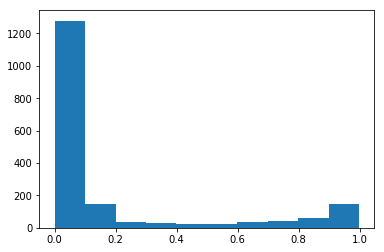

In [32]:
plt.hist(predictions_val)

In [33]:
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu().where(Y_dev.cpu() == torch.tensor(1.), torch.tensor(0.)),
                         np.round(predictions_val), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.931
F1: 0.806
Recall: 0.756
Precision: 0.864


In [34]:
predictions_everything = []
for i in range(0, L_unlabelled_ts.shape[0], 100000):
    print(i)
    start = i
    end = i + 100000
    labels = L_unlabelled_ts[start:end] if end < L_unlabelled_ts.shape[0] else L_unlabelled_ts[start:]
    predictions_for_labels = model.eval().predict_element_proba(labels.to(device))
    predictions_everything.append(predictions_for_labels)
    del predictions_for_labels
    torch.cuda.empty_cache()

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000


In [35]:
np.concatenate(predictions_everything).shape

(6175405,)

In [36]:
R_pred_probs_per_frame = np.concatenate(predictions_everything)

(array([3759959.,  734106.,  692494.,  145111.,  139209.,   97392.,
         131007.,  160536.,  158791.,  156800.]),
 array([1.41829968e-07, 9.99912640e-02, 1.99982386e-01, 2.99973508e-01,
        3.99964631e-01, 4.99955753e-01, 5.99946875e-01, 6.99937997e-01,
        7.99929120e-01, 8.99920242e-01, 9.99911364e-01]),
 <a list of 10 Patch objects>)

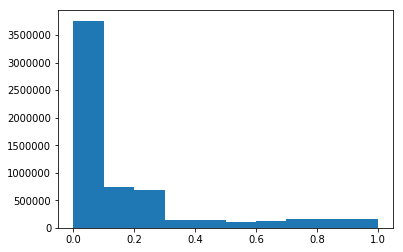

In [37]:
plt.hist(R_pred_probs_per_frame)

In [57]:
L_unlabelled_ts[-10:]

tensor([[2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0,
         0],
        [1, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 1, 0, 2, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0,
         0]])

# Save predictions to disk

In [38]:
window_nums = [
    (video_id, intrvl.start, intrvl.end)
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]

In [39]:
predictions_to_save_windows = [
    (window_info, np.array([prediction, 1. - prediction]))
    for window_info, prediction in zip(window_nums, R_pred_probs_per_frame)
]

In [40]:
# Because we needed to cut the predictions to a multiple of T
last_preds = []
for window_info in window_nums[len(predictions_to_save_windows):]:
    last_preds.append((window_info, np.array([0., 1.])))

In [41]:
last_preds

[]

In [ ]:
predictions_to_save_windows += last_preds

In [42]:
preds_np_windows = np.array(predictions_to_save_windows)

In [43]:
# save predictions to disk
with open('../../data/shot_detection_weak_labels/ts_weak_labels_all_windows_tuned_downsampled_same_val_test.npy', 'wb') as f:
    np.save(f, preds_np_windows)